In [3]:
print("Hello, Programmers!")

Hello, Programmers!


In [4]:
pip install -q numpy pandas matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [13]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)

print("✅Dataset loaded successfully.")
print(f"\📊 Dataset shape: {df.shape}")
print(f"\n🔍 Sample data:\n{df.sample(5)}")
print(f"\n📋 Dataset INFO: {df.info()}")
print(f"\n❌ Missing values: {df.isnull().sum()}")

✅Dataset loaded successfully.
\📊 Dataset shape: (7043, 21)

🔍 Sample data:
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
6521  1092-WPIVQ  Female              0     Yes        Yes      18   
946   6231-WFGFH    Male              0     Yes        Yes       4   
2675  4878-BUNFV    Male              0     Yes        Yes      42   
3913  8749-TZYEC    Male              0     Yes         No      72   
6719  2509-TFPJU    Male              0     Yes         No      72   

     PhoneService MultipleLines InternetService       OnlineSecurity  \
6521          Yes           Yes              No  No internet service   
946           Yes            No              No  No internet service   
2675          Yes            No              No  No internet service   
3913          Yes           Yes              No  No internet service   
6719          Yes           Yes              No  No internet service   

             OnlineBackup     DeviceProtection          TechSupport  \


## Data Cleaning

In [14]:
# datatpe conversion and missing value handling

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
print("✅ Converted 'TotalCharges' to numeric and handled missing values.")

✅ Converted 'TotalCharges' to numeric and handled missing values.


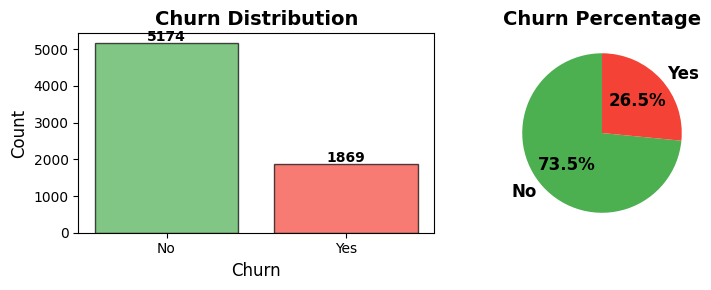

Churn Rate: 26.54%


In [23]:
# Target variable value counts

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

#countplot
churn_counts = df['Churn'].value_counts() # x-index, y-values
colors = ['#4CAF50', '#F44336']
axes[0].bar(churn_counts.index, churn_counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

#pie chart
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_counts[1] / churn_counts.sum():.2%}")

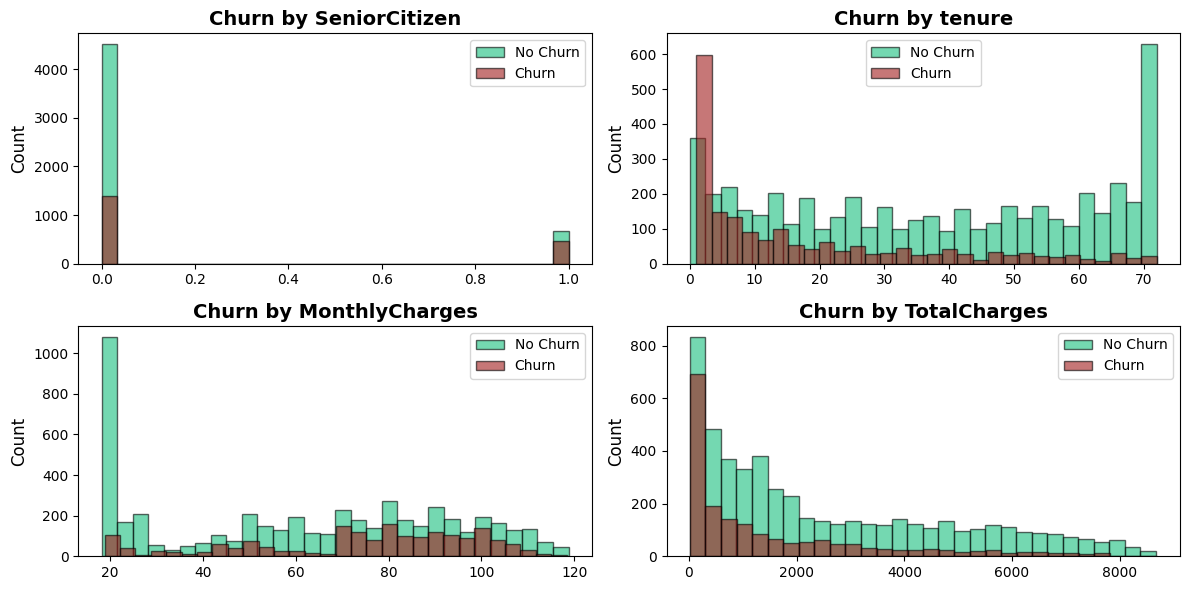

📈Numerical columns Summary INFO:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2281.916928
std         0.368612    24.559481       30.090047   2265.270398
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000


In [46]:
# numerical feature distributions
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, col in enumerate(numerical_cols[:4]):
    axes[i//2, i%2].hist(df[df['Churn'] == 'No'][col], bins=30, alpha=0.6, label='No Churn', color="#17BE7E09", edgecolor='black')
    axes[i//2, i%2].hist(df[df['Churn'] == 'Yes'][col], bins=30, alpha=0.6, label='Churn', color="#A01C1C", edgecolor='black')
    axes[i//2, i%2].legend()
    axes[i//2, i%2].set_title(f'Churn by {col}', fontsize=14, fontweight='bold')
    axes[i//2, i%2].set_ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

print(f"📈Numerical columns Summary INFO:\n{df.describe()}")

In [ ]:
#

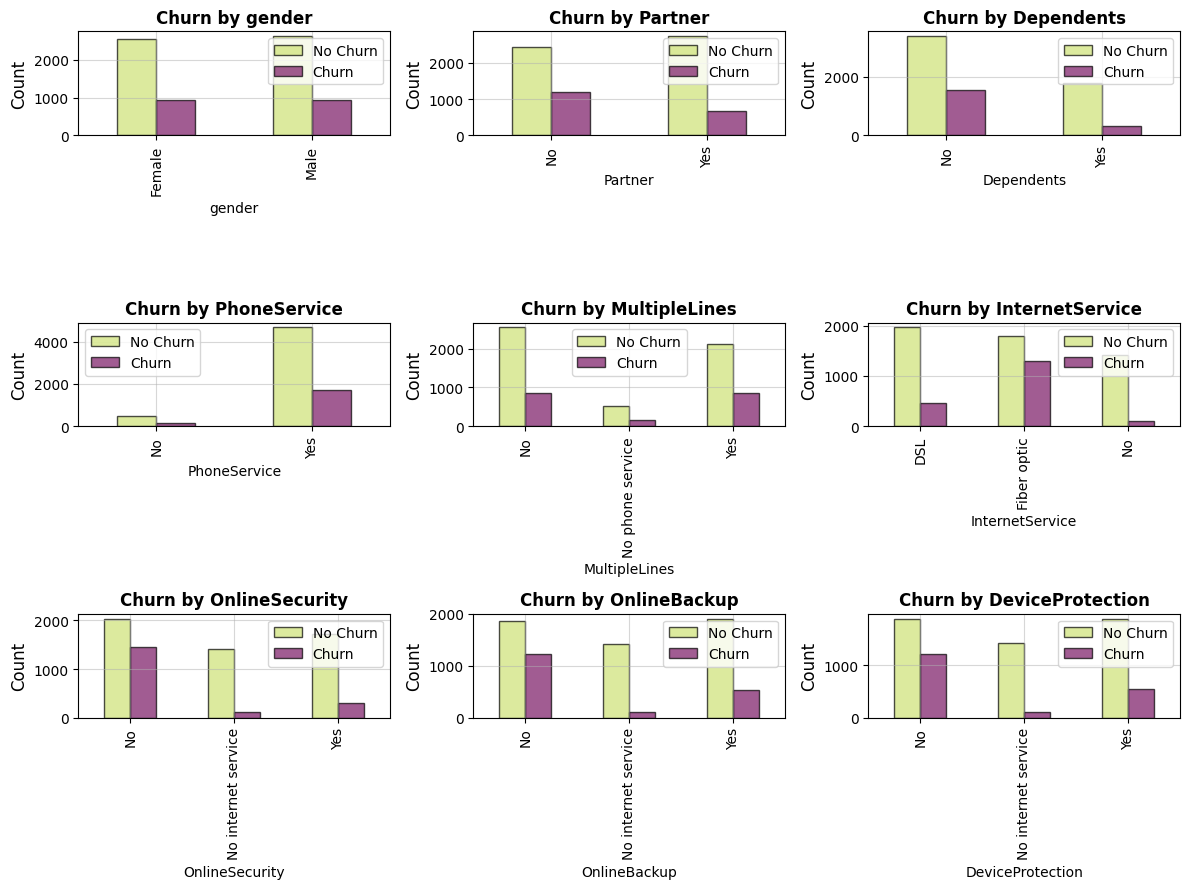

In [91]:
# categorical feature distributions

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, col in enumerate(categorical_cols[:9]):
    ct = pd.crosstab(df[col], df['Churn'])
    ct.plot(kind='bar', stacked=False, ax=axes[i//3, i%3], color=["#CEE275", "#7A1764"], edgecolor='black', alpha=0.7)
    axes[i//3, i%3].set_title(f'Churn by {col}', fontweight='bold')
    axes[i//3, i%3].set_ylabel('Count', fontsize=12)
    axes[i//3, i%3].legend(["No Churn", "Churn"])
    axes[i//3, i%3].grid(alpha=0.5)

plt.tight_layout()
plt.show()

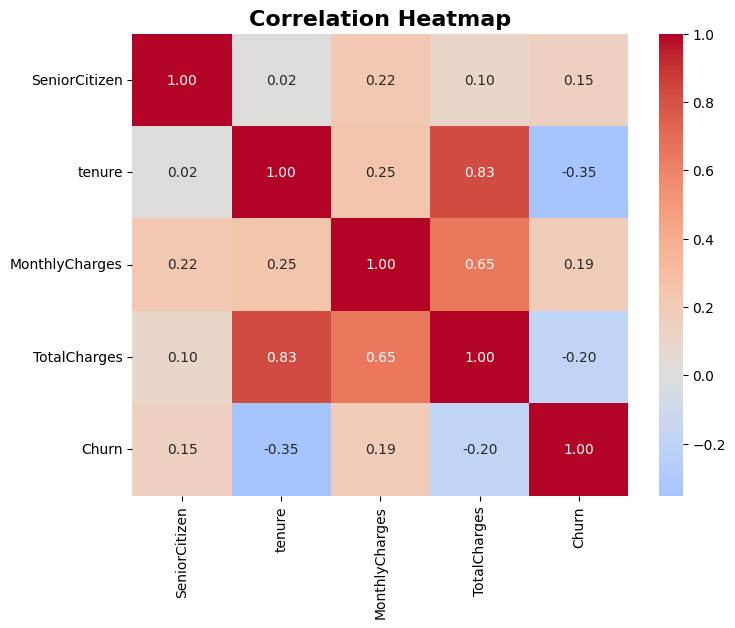

📊 Features more correlated with Churn:
Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199037
tenure           -0.352229
Name: Churn, dtype: float64


In [93]:
# Correlation heatmap

plt.figure(figsize=(8, 6))
df_corr = df.select_dtypes(include=['int64', 'float64']).copy()
df_corr['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
corr = df_corr.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()
print(f"📊 Features more correlated with Churn:\n{corr['Churn'].sort_values(ascending=False)}")